In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf /content/ArASL_Database_54K_Final #Run this cell to delete folder

In [ ]:
!unzip /content/drive/MyDrive/490_Ismaani_Dataset/ArASL_Database_54K_Final.zip &> \dev\null
#Run this cell to re-extract

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import os.path as osp
import cv2
from sklearn.model_selection import train_test_split

X = []
y = []
path = '/content/ArASL_Database_54K_Final'
letters = []

for letter in os.listdir(path):
  for image_file in os.listdir(osp.join(path, letter)):
    img = cv2.imread(osp.join(path,letter,image_file)) # Add ,0 for grayscale
    img = cv2.resize(img,(64,64)) # Resize as not all images are 64x64, some are outliers
    #img = img[..., np.newaxis]
    X.append(img)
    y.append(letter)
  letters.append(letter)
letters.sort()

X = np.array(X); y = np.array(y);
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

roman_to_arab = {
    'aleff': 'أ',
    'bb': 'ب',
    'taa': 'ت',
    'thaa': 'ث',
    'jeem': 'ج',
    'haa': 'ح',
    'khaa': 'خ',
    'dal': 'د',
    'thal': 'ذ',
    'ra': 'ر',
    'zay': 'ز',
    'seen': 'س',
    'sheen': 'ش',
    'saad': 'ص',
    'dhad': 'ض',
    'ta': 'ط',
    'dha': 'ظ',
    'ain': 'ع',
    'ghain': 'غ',
    'fa': 'ف',
    'gaaf': 'ق',
    'kaaf': 'ك',
    'laam': 'ل',
    'meem': 'م',
    'nun': 'ن',
    'ha': 'ه',
    'waw': 'و',
    'ya': 'ئ',
    'toot': 'ة',
    'al': 'ال',
    'la': 'لا',
    'yaa': 'ي'
}

(54049, 64, 64, 3) (54049,)


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.backend import clear_session
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

# Encoding labels as one-hot
lookup = layers.StringLookup(vocabulary=letters,output_mode="one_hot",num_oov_indices=0)
y_train_oh = lookup(y_train)
y_test_oh = lookup(y_test)

# Preparing dataset for input
input_shape = X_train.shape[1:]
num_classes = 32 # Size of letters array
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_oh))

tf.random.set_seed(12)

# ResNet-50

In [ ]:
# Creating input pipeline for pre-implemented ResNet50 Architecture
clear_session()
inputs = keras.Input(shape=input_shape)
# normalized = layers.Normalization()(inputs)
# rescaled = layers.Rescaling(1.0 / 255)(inputs)
preprocessed = preprocess_input(inputs)
outputs = ResNet50(weights=None, input_tensor=inputs, classes=num_classes)(preprocessed)
rn50 = keras.Model(inputs, outputs)
rn50.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']) # Optimizer and loss to be calibrated later

rn50.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 64, 64, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 32)                23653280  
                                                                 
Total params: 23,653,280
Trainable params: 23,600,160
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# Fit the model
rn50_path = "rn50/cp.ckpt"
rn50_dir = os.path.dirname(rn50_path)
rn50_callback = tf.keras.callbacks.ModelCheckpoint(filepath=rn50_path,
                                                 save_weights_only=True,
                                                 verbose=1)
start = datetime.now()
rn50_hist = rn50.fit(X_train,y_train_oh,epochs=20, validation_split=0.2, batch_size=128,callbacks=[rn50_callback])
end = datetime.now()
print(f"RN50 Training Time: {end-start}")

Epoch 1/20
271/271 [==============================] - ETA: 0s - loss: 1.7234 - accuracy: 0.5394
Epoch 00001: saving model to rn50/cp.ckpt
271/271 [==============================] - 102s 311ms/step - loss: 1.7234 - accuracy: 0.5394 - val_loss: 0.7350 - val_accuracy: 0.7375
Epoch 2/20
271/271 [==============================] - ETA: 0s - loss: 0.5373 - accuracy: 0.8650
Epoch 00002: saving model to rn50/cp.ckpt
271/271 [==============================] - 81s 300ms/step - loss: 0.5373 - accuracy: 0.8650 - val_loss: 0.3741 - val_accuracy: 0.9014
Epoch 3/20
271/271 [==============================] - ETA: 0s - loss: 0.3302 - accuracy: 0.9123
Epoch 00003: saving model to rn50/cp.ckpt
271/271 [==============================] - 81s 300ms/step - loss: 0.3302 - accuracy: 0.9123 - val_loss: 0.2598 - val_accuracy: 0.9250
Epoch 4/20
271/271 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9703
Epoch 00004: saving model to rn50/cp.ckpt
271/271 [==============================] - 86

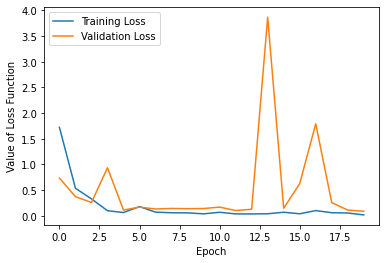

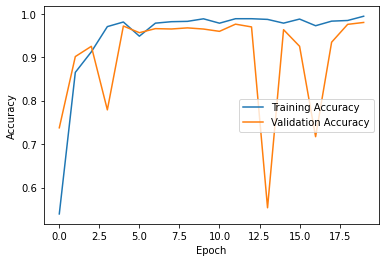

In [ ]:
# Plotting RN50 loss and accuracy
plt.figure()
plt.plot(rn50_hist.history['loss'])
plt.plot(rn50_hist.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Value of Loss Function')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

plt.figure()
plt.plot(rn50_hist.history['accuracy'])
plt.plot(rn50_hist.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [ ]:
# Evaluating precision, recall, and accuracy on test set
#rn50.load_weights("/content/drive/MyDrive/rn50/cp.ckpt")

loss, accuracy = rn50.evaluate(X_test, y_test_oh, verbose=0)
print(f"Loss: {loss}, Accuracy: {accuracy}")
y_pred = rn50.predict(X_test, verbose=0)

y_testi = np.asarray(y_test_oh).nonzero()[1]
y_predi = np.argmax(y_pred,axis=1)
print(classification_report(y_testi, y_predi))

Loss: 0.08828285336494446, Accuracy: 0.9786309003829956
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       415
           1       1.00      0.98      0.99       270
           2       0.96      0.96      0.96       353
           3       0.96      0.99      0.98       366
           4       0.99      0.96      0.98       315
           5       0.98      0.95      0.96       330
           6       0.99      0.99      0.99       292
           7       0.97      0.97      0.97       397
           8       0.97      0.97      0.97       325
           9       1.00      0.99      0.99       418
          10       0.96      0.97      0.96       310
          11       0.98      0.97      0.97       319
          12       0.97      0.97      0.97       321
          13       0.98      0.99      0.98       374
          14       0.97      0.99      0.98       329
          15       0.99      0.99      0.99       357
          16       0.98  

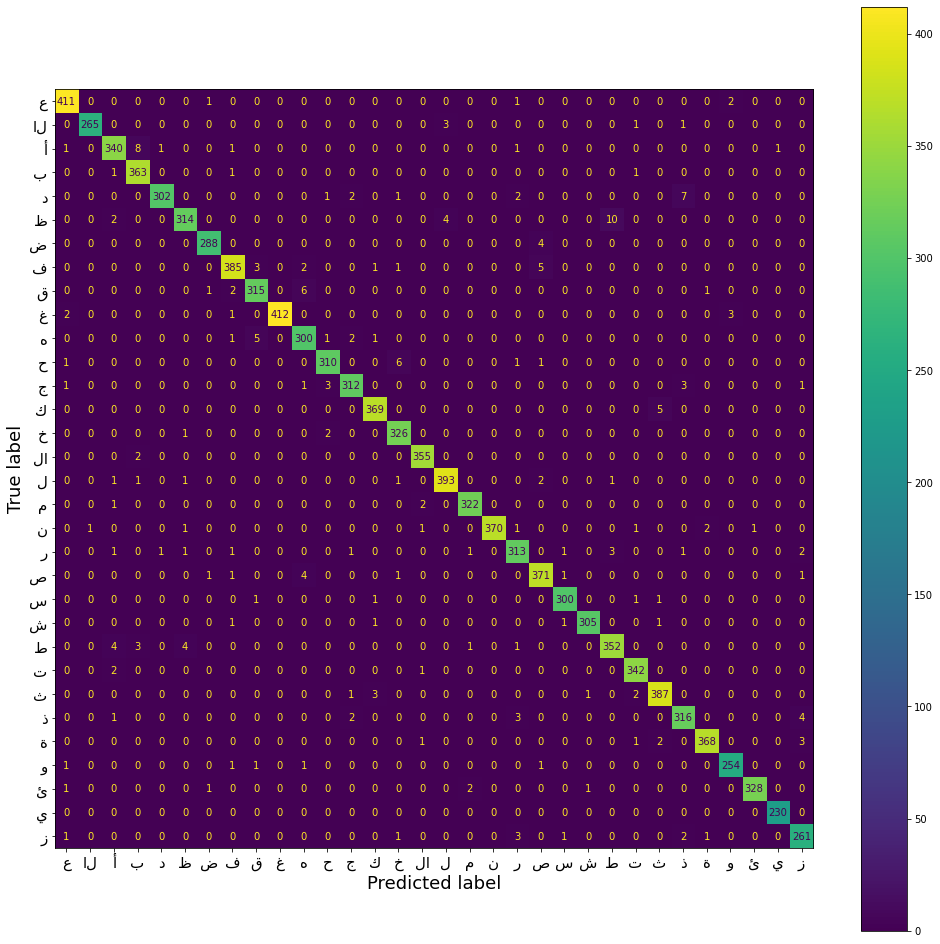

In [ ]:
fig, ax = plt.subplots(figsize=(17, 17))
ax.tick_params(axis='both', which='major', labelsize=15)
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);
ConfusionMatrixDisplay.from_predictions(y_testi, y_predi, display_labels=[roman_to_arab[letter] for letter in letters], ax=ax)

# ResNet-18



In [ ]:
# Custom ResNet Architecture
# Adapted from https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net(input_shape, classes, num_blocks_list=[2, 2, 2, 2]):
    
    inputs = Input(shape=input_shape)
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=7,
               strides=2,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(classes, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# ResNet-18
rn18 = create_res_net(input_shape, num_classes, [2,2,2,2])
rn18.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 3)   12          ['input_2[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['batch_normalization[0][0]']    
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 64)   0           ['conv2d[0][0]']           

In [ ]:
rn18_path = "rn18/cp.ckpt"
rn18_dir = os.path.dirname(rn18_path)
rn18_callback = tf.keras.callbacks.ModelCheckpoint(filepath=rn18_path,
                                                 save_weights_only=True,
                                                 verbose=1)
start = datetime.now()
rn18_hist = rn18.fit(X_train, y_train_oh, epochs=20, validation_split=0.2, batch_size=128,callbacks=[rn18_callback])
end = datetime.now()
print(f"RN18 Training Time: {end-start}")

Epoch 1/20
271/271 [==============================] - ETA: 0s - loss: 0.8051 - accuracy: 0.7659
Epoch 00001: saving model to rn18/cp.ckpt
271/271 [==============================] - 81s 280ms/step - loss: 0.8051 - accuracy: 0.7659 - val_loss: 0.5079 - val_accuracy: 0.8429
Epoch 2/20
271/271 [==============================] - ETA: 0s - loss: 0.1600 - accuracy: 0.9529
Epoch 00002: saving model to rn18/cp.ckpt
271/271 [==============================] - 73s 269ms/step - loss: 0.1600 - accuracy: 0.9529 - val_loss: 0.1278 - val_accuracy: 0.9628
Epoch 3/20
271/271 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9720
Epoch 00003: saving model to rn18/cp.ckpt
271/271 [==============================] - 73s 269ms/step - loss: 0.0960 - accuracy: 0.9720 - val_loss: 0.2642 - val_accuracy: 0.9248
Epoch 4/20
271/271 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9786
Epoch 00004: saving model to rn18/cp.ckpt
271/271 [==============================] - 73s

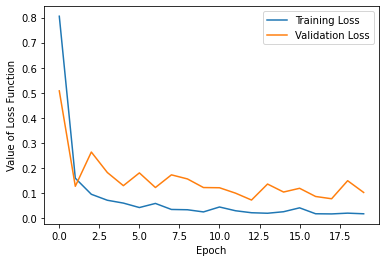

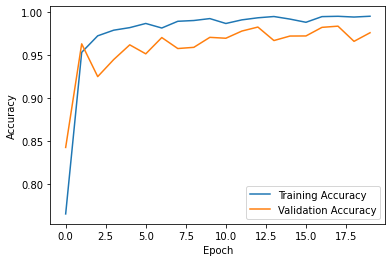

Loss: 0.08534230291843414, Accuracy: 0.9801110029220581
              precision    recall  f1-score   support

           0       0.94      1.00      0.96       415
           1       0.99      0.99      0.99       270
           2       0.97      0.99      0.98       353
           3       0.98      0.98      0.98       366
           4       0.95      0.99      0.97       315
           5       0.98      0.97      0.98       330
           6       0.97      1.00      0.98       292
           7       0.94      0.98      0.96       397
           8       0.98      0.98      0.98       325
           9       0.99      0.95      0.97       418
          10       0.98      0.94      0.96       310
          11       0.95      0.98      0.97       319
          12       0.98      0.97      0.98       321
          13       0.99      0.99      0.99       374
          14       0.97      0.98      0.98       329
          15       1.00      0.99      0.99       357
          16       1.00  

In [ ]:
plt.figure()
plt.plot(rn18_hist.history['loss'])
plt.plot(rn18_hist.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Value of Loss Function')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

plt.figure()
plt.plot(rn18_hist.history['accuracy'])
plt.plot(rn18_hist.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [ ]:
rn18.load_weights('/content/drive/MyDrive/rn18/cp.ckpt')

loss, accuracy = rn18.evaluate(X_test, y_test_oh, verbose=0)
print(f"Loss: {loss}, Accuracy: {accuracy}")
y_pred = rn18.predict(X_test, verbose=0)

y_testi = np.asarray(y_test_oh).nonzero()[1]
y_predi = np.argmax(y_pred,axis=1)
print(classification_report(y_testi, y_predi))

Loss: 0.052833396941423416, Accuracy: 0.9857539534568787
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       432
           1       1.00      1.00      1.00       257
           2       0.97      0.99      0.98       318
           3       0.99      0.99      0.99       364
           4       0.97      1.00      0.99       343
           5       0.99      0.96      0.98       328
           6       0.98      0.99      0.99       329
           7       0.93      1.00      0.96       409
           8       0.97      0.97      0.97       312
           9       1.00      0.98      0.99       399
          10       0.99      0.94      0.96       311
          11       0.97      0.99      0.98       313
          12       0.99      0.98      0.99       312
          13       0.99      0.99      0.99       347
          14       0.97      0.99      0.98       338
          15       1.00      0.99      0.99       374
          16       1.00 

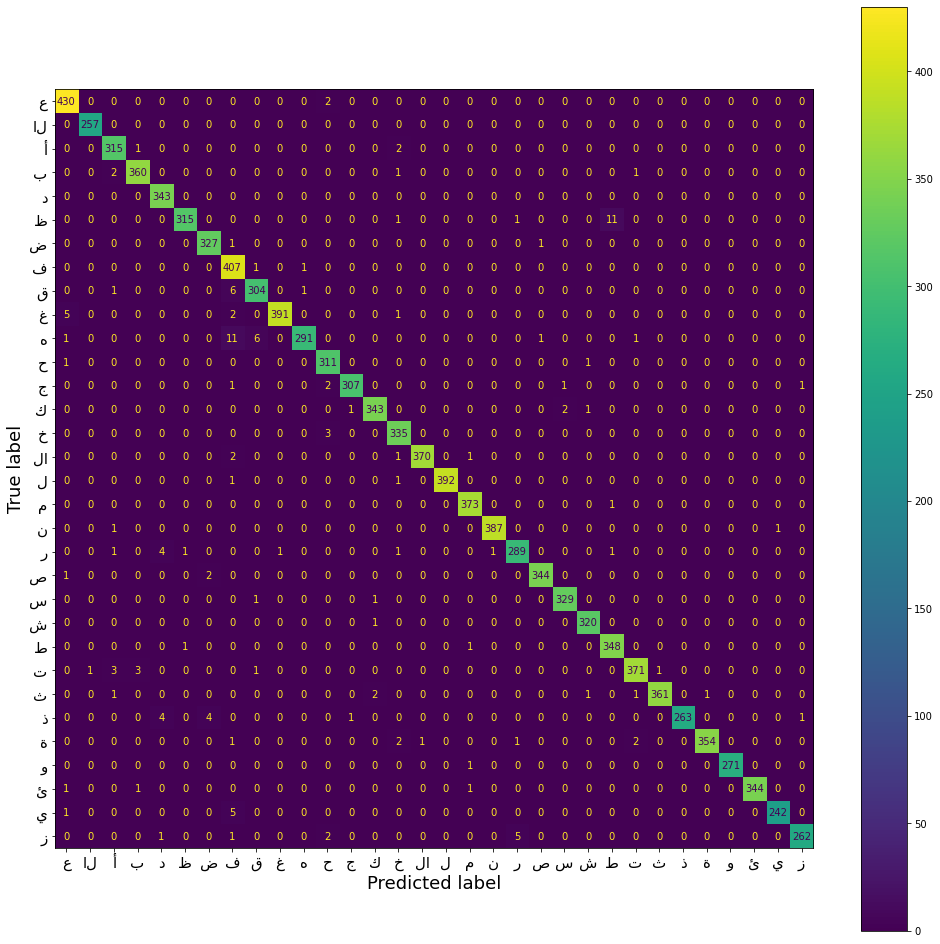

In [ ]:
# Plotting confusion Matrix for ResNet-18
fig, ax = plt.subplots(figsize=(17, 17))
ax.tick_params(axis='both', which='major', labelsize=15)
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);
ConfusionMatrixDisplay.from_predictions(y_testi, y_predi, display_labels=[roman_to_arab[letter] for letter in letters], ax=ax)

# ResNet-10

In [ ]:
# Trying out smaller model: ResNet-10
rn10 = create_res_net(input_shape, num_classes, [1,1,1,1])
rn10.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 batch_normalization_18 (BatchN  (None, 64, 64, 3)   12          ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 32, 64)   9472        ['batch_normalization_18[0][0]'] 
                                                                                                  
 re_lu_17 (ReLU)                (None, 32, 32, 64)   0           ['conv2d_20[0][0]']        

In [ ]:
rn10_path = "rn10/cp.ckpt"
rn10_dir = os.path.dirname(rn10_path)
rn10_callback = tf.keras.callbacks.ModelCheckpoint(filepath=rn10_path,
                                                 save_weights_only=True,
                                                 verbose=1)
start = datetime.now()
rn10_hist = rn10.fit(X_train, y_train_oh, epochs=20, validation_split=0.2, batch_size=128,callbacks=[rn10_callback])
end = datetime.now()
print(f"RN10 Training Time: {end-start}")

Epoch 1/20
271/271 [==============================] - ETA: 0s - loss: 0.6985 - accuracy: 0.8025
Epoch 00001: saving model to rn10/cp.ckpt
271/271 [==============================] - 47s 167ms/step - loss: 0.6985 - accuracy: 0.8025 - val_loss: 0.3263 - val_accuracy: 0.9038
Epoch 2/20
271/271 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.9681
Epoch 00002: saving model to rn10/cp.ckpt
271/271 [==============================] - 45s 165ms/step - loss: 0.1148 - accuracy: 0.9681 - val_loss: 0.1498 - val_accuracy: 0.9620
Epoch 3/20
271/271 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9814
Epoch 00003: saving model to rn10/cp.ckpt
271/271 [==============================] - 45s 165ms/step - loss: 0.0651 - accuracy: 0.9814 - val_loss: 0.1471 - val_accuracy: 0.9594
Epoch 4/20
271/271 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9878
Epoch 00004: saving model to rn10/cp.ckpt
271/271 [==============================] - 45s

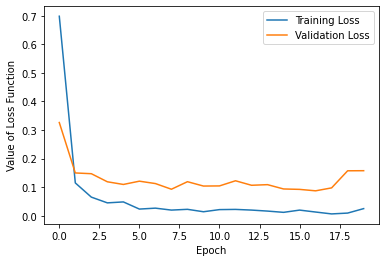

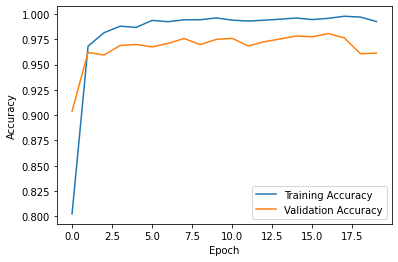

Loss: 0.15354208648204803, Accuracy: 0.963644802570343
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       415
           1       0.96      1.00      0.98       270
           2       0.94      0.98      0.96       353
           3       0.98      0.96      0.97       366
           4       0.98      0.98      0.98       315
           5       0.99      0.93      0.96       330
           6       0.94      0.99      0.97       292
           7       0.96      0.95      0.96       397
           8       0.94      0.97      0.96       325
           9       0.97      0.94      0.96       418
          10       0.96      0.95      0.95       310
          11       0.98      0.93      0.96       319
          12       0.99      0.97      0.98       321
          13       0.97      0.99      0.98       374
          14       0.94      0.98      0.96       329
          15       0.99      0.99      0.99       357
          16       0.99   

In [ ]:
plt.figure()
plt.plot(rn10_hist.history['loss'])
plt.plot(rn10_hist.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Value of Loss Function')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

plt.figure()
plt.plot(rn10_hist.history['accuracy'])
plt.plot(rn10_hist.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

loss, accuracy = rn10.evaluate(X_test, y_test_oh, verbose=0)
print(f"Loss: {loss}, Accuracy: {accuracy}")
y_pred = rn10.predict(X_test, verbose=0)

y_testi = np.asarray(y_test_oh).nonzero()[1]
y_predi = np.argmax(y_pred,axis=1)
print(classification_report(y_testi, y_predi))

In [ ]:
#!cp -r /content/rn10 /content/drive/MyDrive
#!cp -r /content/rn18 /content/drive/MyDrive
!cp -r /content/rn50 /content/drive/MyDrive

(64, 64, 3)


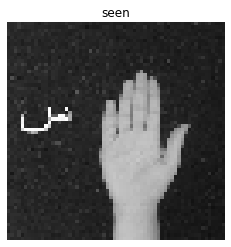

[[3.4530723e-07 6.4089072e-05 6.1064595e-05 8.4050775e-08 1.1518412e-04
  2.5422744e-06 3.6120499e-04 8.1937857e-02 2.7875982e-03 5.7187275e-04
  7.5400692e-01 3.9546575e-07 1.8403509e-03 7.7988226e-03 5.4514970e-07
  6.8043690e-04 3.1465331e-07 2.6049718e-04 4.6089666e-05 2.3857144e-06
  6.6740714e-02 1.4922920e-02 6.1524812e-02 3.8350514e-05 2.0279793e-05
  8.6779699e-05 1.1402598e-03 1.1273474e-03 1.1423692e-03 2.6611919e-03
  7.1644745e-06 4.9257691e-05]]
Prediction: ha
Incorrectly predicted.
(64, 64, 3)


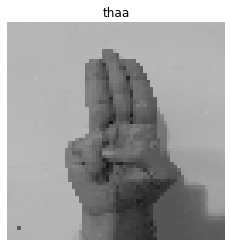

[[9.16562173e-11 9.53233439e-08 2.51666393e-06 1.56623130e-07
  1.57714954e-12 6.75059231e-10 9.89735183e-10 1.88874916e-09
  3.98213373e-09 1.16420840e-09 2.56687542e-08 1.40488792e-12
  1.98937009e-08 2.01593707e-07 1.80749316e-09 2.48859386e-08
  2.41817510e-10 1.11355515e-10 4.39664660e-08 9.52029219e-11
  5.81798359e-11 3.21559246e-09 5.10120557e-10 2.56069194e-10
  9.06266496e-02 9.09300506e-01 2.07937347e-08 6.97803407e-05
  1.50261226e-08 1.48919991e-11 5.89735905e-09 8.49311177e-11]]
Prediction: thaa
Correctly predicted.
(64, 64, 3)


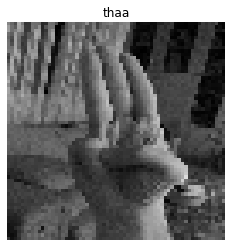

[[8.7860430e-10 9.3682516e-01 5.9950757e-08 3.5948165e-11 1.1745437e-09
  1.2794370e-06 5.0928971e-08 2.1177252e-08 6.6457270e-04 6.9523281e-08
  3.5376416e-10 8.5362100e-15 9.0486481e-07 1.5644565e-10 3.8219934e-11
  9.1467712e-08 1.3018521e-07 2.5852216e-06 2.2977499e-06 1.0212960e-10
  2.4781557e-10 7.4696320e-09 2.1483338e-06 8.8350003e-09 9.8136161e-06
  1.4221262e-04 1.6060735e-04 6.2185925e-02 1.4734530e-08 1.1606779e-06
  7.0974158e-07 1.4004446e-07]]
Prediction: al
Incorrectly predicted.
(64, 64, 3)


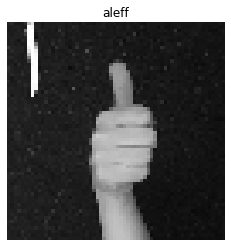

[[1.71740573e-11 7.34812711e-05 2.72999500e-07 1.27104604e-05
  2.20676228e-07 4.55262929e-01 3.58037766e-11 6.80732207e-11
  5.18267562e-09 3.47604101e-09 7.72600484e-10 4.21088999e-13
  1.53933241e-10 3.17299520e-11 6.55470886e-11 3.56190285e-04
  1.68024030e-07 1.18359174e-04 8.50076758e-05 5.43808460e-01
  2.48212692e-12 6.12504492e-09 1.09741325e-06 1.48104518e-04
  3.14551656e-08 3.42425532e-11 4.68056538e-10 1.31529436e-04
  5.34775911e-14 3.21496110e-08 2.51696122e-07 1.08944960e-06]]
Prediction: ra
Incorrectly predicted.
(64, 64, 3)


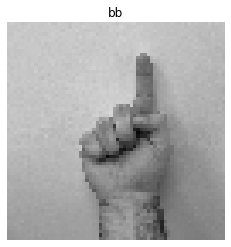

[[9.7692716e-09 4.9012408e-07 1.4842425e-05 6.4892089e-01 6.2046951e-07
  6.9857458e-07 9.3672516e-06 1.1832838e-05 3.5436304e-10 2.6489982e-07
  3.2241289e-06 2.0225428e-09 5.7726226e-07 3.4923087e-07 8.6999357e-08
  4.4556949e-05 7.9238461e-04 2.2959981e-05 3.2918133e-06 3.1545147e-05
  3.5003519e-01 1.1099572e-06 2.4183546e-09 4.6864854e-05 5.6326498e-05
  4.8298049e-10 4.5349384e-07 9.7932923e-07 1.7287478e-10 3.5331144e-07
  6.1003618e-07 9.5027211e-08]]
Prediction: bb
Correctly predicted.
(64, 64, 3)


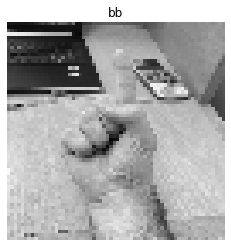

[[1.9426547e-05 1.0189404e-03 2.2334405e-03 4.3904289e-05 4.5684708e-04
  5.1938649e-04 2.3510249e-03 3.5130733e-03 9.8816316e-05 7.2290398e-02
  1.0535361e-05 1.9482455e-08 8.6128816e-02 5.7321954e-06 6.0598581e-04
  3.9841625e-06 8.4964262e-04 4.3225532e-06 2.8923830e-02 1.3577918e-04
  5.3932564e-04 1.3515029e-04 5.5465002e-06 2.6243541e-03 4.6569281e-04
  7.3838688e-05 7.7865243e-01 8.4904244e-04 1.6223166e-02 2.7731234e-05
  5.2692811e-04 6.6278741e-04]]
Prediction: thal
Incorrectly predicted.


In [ ]:
rn50.load_weights('rn50/cp.ckpt')

for label in os.listdir('/content/drive/MyDrive/pics'):
  for test_img_file in os.listdir(f'/content/drive/MyDrive/pics/{label}'):
    test_img = cv2.imread(f'/content/drive/MyDrive/pics/{label}/{test_img_file}')
    test_img = cv2.resize(test_img,(64,64))
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_GRAY2RGB)
    print(test_img.shape)

    plt.figure()
    plt.axis('off')
    plt.imshow(test_img, cmap='Greys')
    plt.title(label)
    plt.show()

    pred_label = rn50.predict(np.array([test_img]),verbose='0')
    print(pred_label)
    pred_label = np.argmax(pred_label)
    print("Prediction:", letters[pred_label])
    if letters[pred_label] == label:
      print("Correctly predicted.")
    else:
      print("Incorrectly predicted.")

(64, 64, 3)


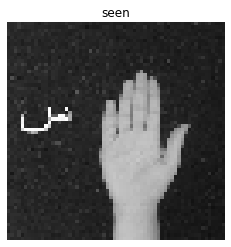

[[1.6223780e-08 2.2632410e-06 3.4784687e-06 2.3507985e-06 3.1822893e-08
  3.4917761e-08 2.1751855e-07 5.2703865e-07 6.2837650e-08 2.6303923e-08
  7.9694189e-08 4.0306611e-07 7.5962940e-05 4.1711139e-08 9.5279402e-09
  1.4850426e-08 2.9285931e-07 1.0160903e-06 9.9131523e-07 7.9268808e-08
  7.6753105e-07 9.9977380e-01 1.0922881e-04 1.5803320e-07 5.0441389e-09
  2.8266686e-07 7.1335691e-08 4.1865403e-10 2.4734714e-05 2.7740891e-06
  2.7920186e-07 1.9701545e-09]]
Prediction: seen
Correctly predicted.
(64, 64, 3)


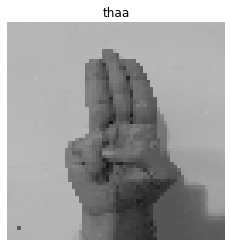

[[1.7808256e-03 1.1301370e-04 5.8830188e-05 2.5078123e-05 3.0675958e-06
  7.7197154e-05 3.9796532e-06 3.5803268e-06 1.1183647e-04 1.7875396e-05
  2.5231598e-04 2.3550460e-04 2.4755680e-06 9.9343387e-04 1.7010998e-03
  9.0084939e-07 3.8631022e-04 4.7917907e-05 3.6818990e-05 2.3582397e-06
  1.1014262e-06 1.4247575e-04 2.5295962e-05 4.2622851e-05 6.9329610e-05
  9.9342394e-01 2.0038585e-06 5.3593626e-06 4.1324581e-04 1.2438735e-05
  7.4208879e-06 4.7431692e-07]]
Prediction: thaa
Correctly predicted.
(64, 64, 3)


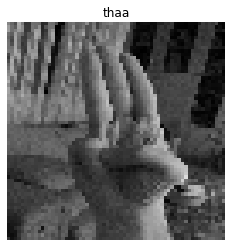

[[1.57339644e-04 1.04571882e-04 3.68262772e-05 3.81957041e-04
  7.14554699e-05 4.44186808e-05 7.26464077e-06 1.29936125e-05
  4.93804800e-05 5.17418528e-07 1.17285737e-04 1.14535983e-03
  5.31316153e-04 1.89753005e-03 2.16255593e-03 1.20617096e-05
  1.78559130e-05 5.23920016e-06 2.69039610e-05 2.34067793e-05
  2.11404858e-06 1.39425916e-04 7.96141976e-05 3.95932439e-05
  1.96914133e-02 9.73112226e-01 2.93070898e-05 5.44721843e-05
  9.34812761e-06 1.00769307e-06 2.21466689e-06 3.29189679e-05]]
Prediction: thaa
Correctly predicted.
(64, 64, 3)


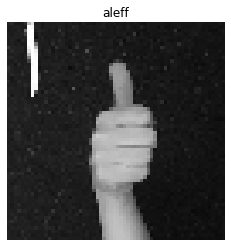

[[6.9593085e-08 1.1148930e-08 9.9986434e-01 5.9740047e-05 2.9440322e-08
  1.9356125e-06 6.2117472e-08 2.0878973e-07 1.4527057e-08 3.1203813e-06
  1.8141290e-06 1.1538257e-08 3.3069012e-09 4.1461203e-06 2.1531042e-07
  3.2819211e-05 5.6733990e-07 4.9275154e-06 2.6206746e-06 1.0636821e-06
  5.4315372e-08 2.9186881e-06 4.1129486e-08 1.3795079e-05 3.0398809e-07
  2.4305634e-06 2.6920217e-09 3.0820655e-07 9.4465612e-08 1.4491090e-07
  2.1042058e-06 2.2432884e-08]]
Prediction: aleff
Correctly predicted.
(64, 64, 3)


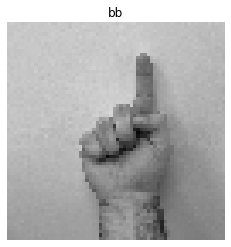

[[1.27844160e-05 1.08329482e-06 7.53005224e-05 6.81317210e-01
  3.72092612e-03 1.49902212e-03 6.71098242e-04 2.57626874e-04
  1.92490828e-04 2.64626169e-06 2.23594694e-03 2.09312202e-04
  1.12141286e-04 9.13640088e-06 1.41085731e-02 2.28648587e-05
  8.35045502e-02 7.25320160e-06 7.21639935e-06 4.43081604e-03
  1.39914051e-01 1.66585742e-05 6.21057211e-07 6.35055313e-03
  1.05953943e-04 3.79256198e-06 1.45912214e-04 1.78647970e-05
  5.06321294e-06 4.00357430e-06 4.42237479e-06 6.10330552e-02]]
Prediction: bb
Correctly predicted.
(64, 64, 3)


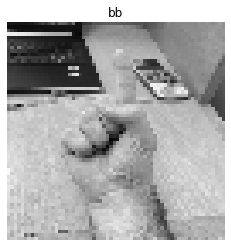

[[1.6780078e-06 2.4709757e-06 1.3463776e-05 4.3066171e-07 1.0039304e-05
  6.0168531e-05 8.1503213e-06 2.7135128e-02 4.2992373e-04 1.3135537e-04
  1.1209055e-05 5.2204081e-07 1.3399269e-07 3.5078774e-08 9.6367991e-01
  7.7281754e-08 4.4196845e-06 4.6272660e-07 2.7031356e-07 1.0758613e-06
  4.9665367e-04 9.4878902e-07 1.4797659e-07 2.1762655e-06 1.5866399e-05
  7.1784513e-07 3.3169868e-05 7.7834793e-06 7.9164943e-03 7.0685417e-07
  3.0767835e-06 3.1309119e-05]]
Prediction: khaa
Incorrectly predicted.


In [ ]:
# To get the true arabic letter from the romanized one, replace letter by roman_to_arab[letter]

rn18.load_weights('/content/drive/MyDrive/rn18/cp.ckpt')

for label in os.listdir('/content/drive/MyDrive/pics'):
  for test_img_file in os.listdir(f'/content/drive/MyDrive/pics/{label}'):
    test_img = cv2.imread(f'/content/drive/MyDrive/pics/{label}/{test_img_file}')
    test_img = cv2.resize(test_img,(64,64))
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_GRAY2RGB)
    print(test_img.shape)

    plt.figure()
    plt.axis('off')
    plt.imshow(test_img, cmap='Greys')
    plt.title(label)
    plt.show()

    pred_label = rn18.predict(np.array([test_img]),verbose='0')
    print(pred_label)
    pred_label = np.argmax(pred_label)
    print("Prediction:", letters[pred_label])
    if letters[pred_label] == label:
      print("Correctly predicted.")
    else:
      print("Incorrectly predicted.")

(64, 64, 3)


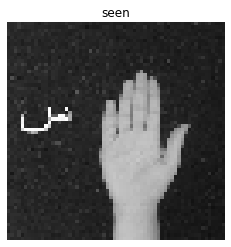

[[1.1378804e-06 6.7886576e-06 3.0182116e-04 2.0978549e-02 3.8232282e-04
  5.1174015e-05 3.4496616e-04 4.9184434e-02 4.7515506e-01 4.5827525e-07
  2.8364408e-01 2.0400675e-03 4.0808278e-03 1.2646072e-01 3.8611933e-04
  9.1576384e-04 4.9953780e-04 7.2219321e-03 8.9507336e-03 4.6875011e-03
  9.1744028e-03 2.8179965e-03 3.2526259e-05 5.8195315e-04 1.6818057e-03
  5.8703081e-05 4.7552672e-05 1.0951116e-04 1.6869604e-05 8.6657470e-05
  3.4978246e-05 6.3151107e-05]]
Prediction: gaaf
Incorrectly predicted.
(64, 64, 3)


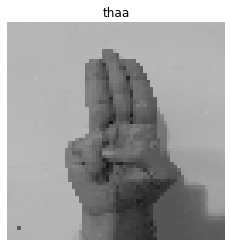

[[7.9740943e-08 4.0154541e-10 1.6400661e-09 3.7886929e-12 5.8527514e-12
  7.1853435e-12 8.1516872e-14 1.1753654e-11 6.5930583e-10 7.1318146e-10
  4.4582258e-11 1.0911494e-09 1.1517938e-12 1.5369779e-09 9.2841623e-10
  1.7089205e-11 5.7192012e-12 5.7485986e-12 2.7012720e-11 1.7031947e-13
  1.4637831e-13 1.3693201e-10 4.6659197e-11 1.4209116e-12 1.9685272e-06
  9.9999785e-01 7.8623240e-11 6.1431205e-10 3.4486528e-11 2.3461514e-13
  1.4011296e-10 4.5341842e-13]]
Prediction: thaa
Correctly predicted.
(64, 64, 3)


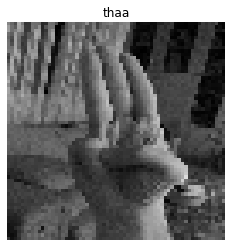

[[1.6581516e-04 2.3874552e-03 2.8872519e-04 1.1885633e-04 5.3991840e-07
  4.4178199e-05 1.6079865e-06 4.8246112e-04 2.1962239e-03 3.1078016e-04
  4.0962015e-05 1.0675782e-05 8.7732287e-06 1.5751667e-03 1.7715201e-06
  4.6336941e-06 5.2307092e-05 4.6307145e-05 6.7584851e-04 2.7411463e-07
  1.0784923e-06 2.8372100e-01 1.8983138e-04 5.7853467e-05 3.6970578e-02
  6.7055357e-01 3.2107848e-05 1.3315018e-05 2.5472707e-05 6.9664948e-06
  9.1753345e-06 5.8142273e-06]]
Prediction: thaa
Correctly predicted.
(64, 64, 3)


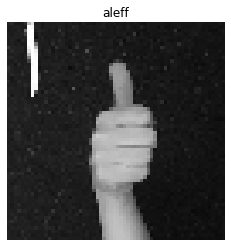

[[4.2861670e-06 1.4978582e-05 1.8127666e-01 5.2550096e-02 4.5108500e-05
  1.0661609e-03 2.7614260e-06 5.3542624e-03 1.9610206e-02 5.3028862e-06
  5.5091072e-02 6.5147440e-05 1.8725066e-05 2.3958957e-01 7.7936267e-05
  1.5995449e-01 2.7766051e-03 6.6253886e-02 1.7013148e-03 1.2790948e-03
  4.3639928e-05 8.7219626e-02 1.8696035e-05 1.6299410e-02 1.0685057e-01
  2.3051784e-03 1.8399396e-06 9.3501221e-05 9.0212313e-07 4.0826897e-05
  5.7402292e-05 3.3077266e-04]]
Prediction: kaaf
Incorrectly predicted.
(64, 64, 3)


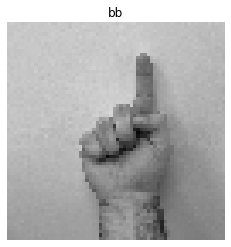

[[7.94306665e-09 3.57780428e-09 7.89401238e-05 5.46004996e-03
  6.27717043e-07 1.87287355e-06 5.44848626e-05 2.80401855e-06
  8.45460857e-09 1.20279722e-07 1.62054377e-07 9.78306058e-09
  1.61341958e-07 4.57449715e-07 5.57942492e-08 1.39169842e-07
  1.14463165e-01 1.12031806e-09 7.83691689e-08 4.52419435e-08
  8.79908741e-01 3.03008346e-06 2.42240255e-08 1.40945701e-06
  1.78742794e-05 2.00984318e-09 2.31718263e-06 2.75634363e-07
  5.96574845e-10 8.60826503e-07 3.97586106e-08 2.27273722e-06]]
Prediction: saad
Incorrectly predicted.
(64, 64, 3)


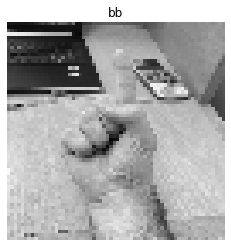

[[7.8095892e-04 6.8987800e-05 3.4980310e-04 6.7593157e-07 8.5837582e-06
  1.2738675e-01 3.6968722e-05 3.1062133e-05 2.4762069e-06 4.8381394e-01
  8.3743352e-08 1.7589130e-04 1.1308761e-06 1.6615036e-06 6.8071252e-03
  1.4442217e-03 2.9134238e-03 1.8442110e-07 4.9641641e-04 1.8437979e-05
  4.0799070e-05 1.3988341e-04 7.2217903e-05 6.5139428e-02 1.7122006e-04
  3.4098866e-04 3.2503700e-03 5.0330902e-05 2.0954292e-01 6.2932505e-04
  2.3371060e-03 9.3946703e-02]]
Prediction: ghain
Incorrectly predicted.


In [ ]:
rn10.load_weights('/content/drive/MyDrive/rn10/cp.ckpt')

for label in os.listdir('/content/drive/MyDrive/pics'):
  for test_img_file in os.listdir(f'/content/drive/MyDrive/pics/{label}'):
    test_img = cv2.imread(f'/content/drive/MyDrive/pics/{label}/{test_img_file}')
    test_img = cv2.resize(test_img,(64,64))
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_GRAY2RGB)
    print(test_img.shape)

    plt.figure()
    plt.axis('off')
    plt.imshow(test_img, cmap='Greys')
    plt.title(label)
    plt.show()

    pred_label = rn10.predict(np.array([test_img]),verbose='0')
    print(pred_label)
    pred_label = np.argmax(pred_label)
    print("Prediction:", letters[pred_label])
    if letters[pred_label] == label:
      print("Correctly predicted.")
    else:
      print("Incorrectly predicted.")